`ProPublica Recidivism/COMPAS` :<br>
    The COMPAS dataset (Correctional Offender Management Profiling for Alternative Sanctions) is a dataset used for binary classification tasks in the field of criminal justice. The goal is to predict whether a defendant will re-offend within two years of release, based on various demographic and criminal history features.<br>
    Reference Link: https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative,print_recourse_report_KStest_cumulative
import matplotlib.pyplot as plt
from aif360.sklearn.datasets import fetch_compas
from facts.utils import load_rules_by_if, save_rules_by_if

from IPython.display import Markdown, display

## Load Dataset

In [2]:
from pathlib import Path

computed_rules_file = Path("..") / "results-cache" / "Compas" / "rulesCompas_atomic.data"
computed_rules_with_cumulative_file = Path("..") / "results-cache" / "Compas" / "rulesCompas_cumulative.data"

In [3]:
X, y = fetch_compas()
X['target'] = y.values

sensitive_attribute = "race"
df = clean_dataset(X,'compas')
y = df['target']
X = df.drop('target', axis=1)

X.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
0,Male,25 - 45,African-American,0,0,0,"(-0.1, 1.0]",F
1,Male,10-25,African-American,0,0,1,"(1.0, 5.0]",F
2,Male,25 - 45,Caucasian,0,0,0,"(10.0, 15.0]",F
3,Female,25 - 45,Caucasian,0,0,0,"(-0.1, 1.0]",M
4,Male,25 - 45,Caucasian,0,0,0,"(-0.1, 1.0]",F


## Model training and test

In [4]:
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='target')
model.predict(X_test.iloc[:100, :])

Wall time: 128 ms


array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       745
           1       0.69      0.71      0.70       837

    accuracy                           0.68      1582
   macro avg       0.68      0.67      0.67      1582
weighted avg       0.68      0.68      0.68      1582



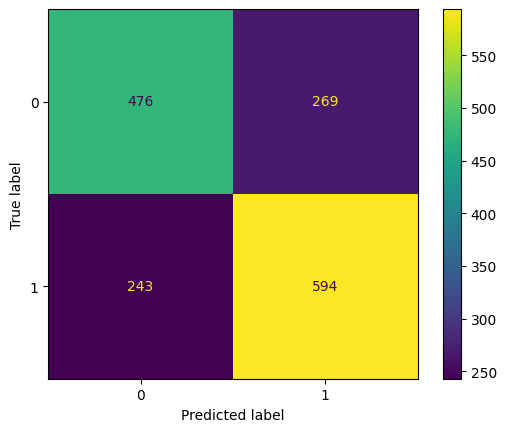

In [7]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Contribution

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [8]:
# #Uncomment if you want to find new rules with different support

# start_time = time.time()
# ifthens_coverage_correctness, stats = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='race',
#     freqitem_minsupp = 0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = False
# )
# end_time = time.time()

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [24]:
# stats["valid-if-thens-time"] = end_time - start_time
# stats["triples-no"] = len(ifthens_coverage_correctness)
# stats["subgroup-no"] = len(rules_by_if)

In [9]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if(computed_rules_file)

## Use this for saving rules on disk
#save_rules_by_if(precomputed_rules_file, rules_by_if)

In [10]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Caucasian"][1][0][1]-e[1]["African-American"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 1.03% covered
		Make age_cat = 25 - 45, c_charge_degree = M, juv_misd_count = 0 with correctness 0.00%.
		Make age_cat = 25 - 45, juv_misd_count = 0 with correctness 0.00%.
		Make age_cat = Greater than 45, juv_misd_count = 0 with correctness 50.00%.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_misd_count = 0 with correctness 50.00%.
		Make c_charge_degree = M, juv_misd_count = 0 with correctness 0.00%.
	Protected Subgroup 'African-American', 2.71% covered
		Make age_cat = 25 - 45, c_charge_degree = M, juv_misd_count = 0 with correctness 85.71%.
		Make age_cat = 25 - 45, juv_misd_count = 0 with correctness 42.86%.
		Make age_cat = Greater than 45, juv_misd_count = 0 with correctness 92.86%.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_misd_count = 0 with correctness 92.86%.
		Make c_charge_degree = M, juv_misd_count = 0 with correctnes

## Macro Viewpoint

In [11]:
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = []
feature_weights = {'sex':100,	'age_cat':10,	'race':100,	'juv_fel_count':1,	'juv_fel_count':1,	'juv_other_count':1,	'priors_count':1,	'c_charge_degree':1}

features_with_binary_cost = cate_features
features_with_proportional_cost = num_features

Xcopy = X.copy()
Xcopy = Xcopy.astype({"age_cat": "object", "race": "object", "c_charge_degree": "object"})
comparators = facts.feature_change_builder(
    Xcopy,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=False,
    #feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

### Equal Cost of Effectiveness (Macro)

In [12]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If c_charge_degree = F, juv_misd_count = 0:
	Protected Subgroup 'Caucasian', 79.49% covered out of 2100
		Make c_charge_degree = M with correctness 50.32%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 72.53% covered out of 3173
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against African-American. Unfairness score = inf.
If c_charge_degree = F, sex = Male:
	Protected Subgroup 'Caucasian', 77.95% covered out of 2100
		Make c_charge_degree = M with correctness 50.66%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 80.66% covered out of 3173
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against African-American. Unfairness score = inf.
If c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 0:
	Protected Subgroup 'Caucasian', 76.92% covered out of 2100
		Make c_charge_degree = M with correctness 52.00%.
		Aggregate cost of t

### Equal Choice for Recourse

In [13]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If age_cat = 25 - 45, c_charge_degree = F:
	Protected Subgroup 'Caucasian', 46.67% covered out of 2100
		Make c_charge_degree = M with correctness 51.65%.
		Make age_cat = Greater than 45 with correctness 60.44%.
		Make age_cat = Greater than 45, c_charge_degree = M with correctness 72.53%.
		Aggregate cost of the above recourses = -3.00
	Protected Subgroup 'African-American', 47.97% covered out of 3173
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Bias against African-American. Unfairness score = 3.
If age_cat = 25 - 45, c_charge_degree = F, juv_misd_count = 0:
	Protected Subgroup 'Caucasian', 45.64% covered out of 2100
		Make c_charge_degree = M with correctness 52.81%.
		Make age_cat = Greater than 45 with correctness 60.67%.
		Make age_cat = Greater than 45, c_charge_degree = M with correctness 71.91%.
		Aggregate cost of the above recourses = -3.00
	Protected Subgroup 'African-American', 39.26% covered out of 3173
		No recourses for this subgrou

## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [62]:
# start_time = time.time()
# rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="race", params=params)
# end_time = time.time()

In [63]:
# stats["cumulative-time"] = end_time - start_time

In [14]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if(computed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(computed_rules_with_cumulative_file, rules_with_cumulative)

# facts.update_costs_cumulative(rules_with_cumulative, params)

### Equal (Conditional) Mean Recourse

If age_cat = 25 - 45, juv_other_count = 2:
	Protected Subgroup 'Caucasian', 2.05% covered out of 171
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 0.29.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 10.29.
		Aggregate cost of the above recourses = 0.29
	Protected Subgroup 'African-American', 1.55% covered out of 548
		Make juv_other_count = 0 with effectiveness 12.50% and counterfactual cost = 0.29.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 10.29.
		Aggregate cost of the above recourses = 7.79
	Bias against African-American due to Equal Effectiveness. Unfairness score = 7.5.
	Cumulative effectiveness plot for the above recourses:


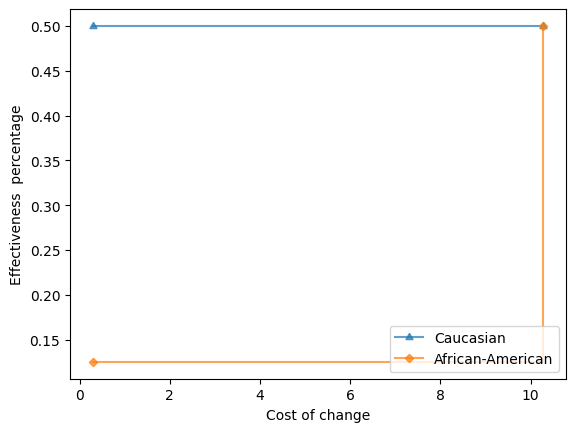

If age_cat = 25 - 45, juv_misd_count = 0, juv_other_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 1.54% covered out of 171
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 0.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 10.14.
		Aggregate cost of the above recourses = 10.14
	Protected Subgroup 'African-American', 3.87% covered out of 548
		Make juv_other_count = 0 with effectiveness 20.00% and counterfactual cost = 0.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 35.00% and counterfactual cost = 10.14.
		Aggregate cost of the above recourses = 4.43
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 5.714.
	Cumulative effectiveness plot for the above recourses:


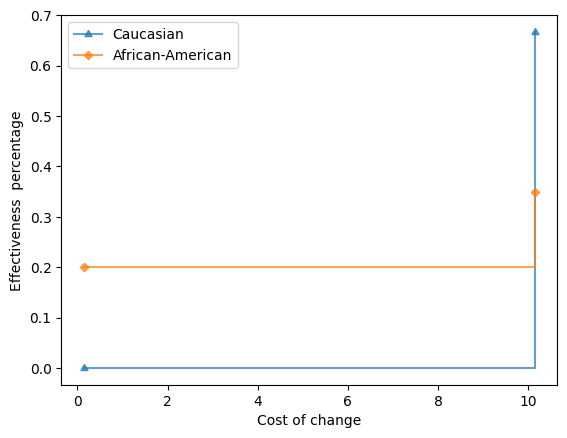

If age_cat = 10-25, juv_other_count = 1, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 66.67% and counterfactual cost = 1.14.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 10.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 10.14.
		Make age_cat = 25 - 45, juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.14.
		Make age_cat = Greater than 45, juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 11.14.
		Aggregate cost of the above recourses = 4.14
	Protected Subgroup 'African-American', 1.93% covered out of 548
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 20.00% and counterfactual cost = 1.14.
		Make age_cat = 25 - 45, juv_other_count

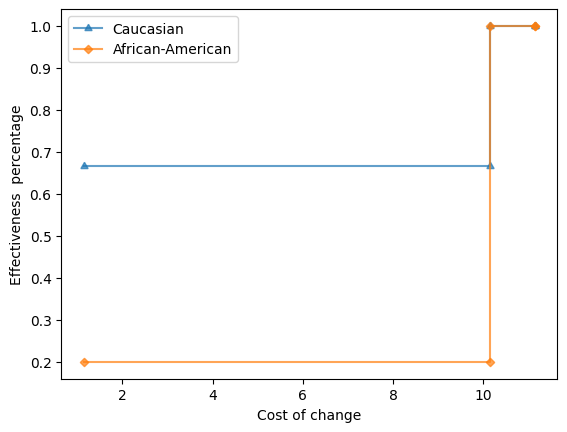

If age_cat = 10-25, juv_misd_count = 0, juv_other_count = 1, priors_count = (-0.1, 1.0], sex = Male:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 0.14.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 10.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 10.14.
		Make age_cat = 25 - 45, juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 11.14.
		Make age_cat = Greater than 45, juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 11.14.
		Aggregate cost of the above recourses = 5.14
	Protected Subgroup 'African-American', 2.32% covered out of 548
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 0.14.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 1

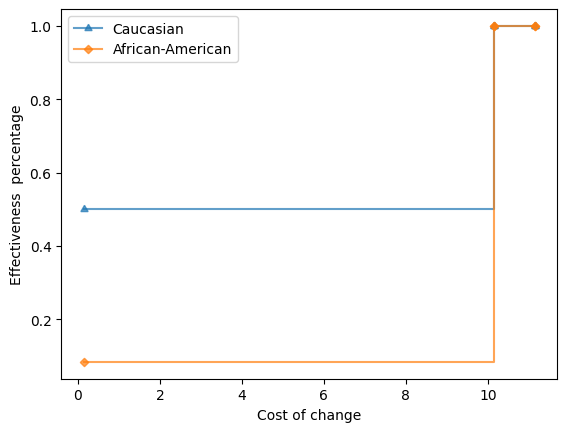

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness

If juv_other_count = 3:
	Protected Subgroup 'Caucasian', 1.54% covered out of 171
		Make juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 0.43.
		Aggregate cost of the above recourses = 0.67
	Protected Subgroup 'African-American', 1.16% covered out of 548
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 0.43.
		Aggregate cost of the above recourses = 0.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.667.
	Cumulative effectiveness plot for the above recourses:


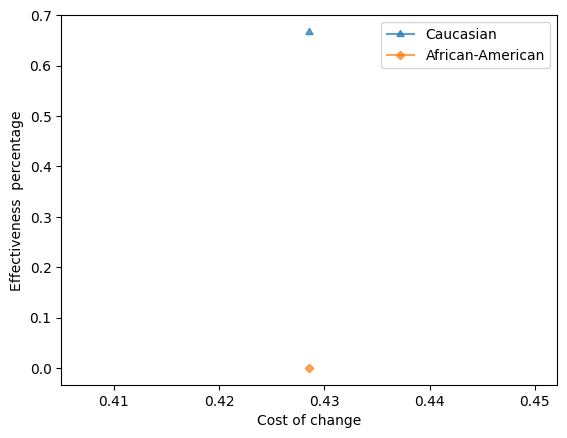

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.08.
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 1.08.
		Make age_cat = 25 - 45, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 10.08.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 10.08.
		Make age_cat = 25 - 45, c_charge_degree = M, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 11.08.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 11.08.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 2.90% covered out of 548
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.08.
		Make 

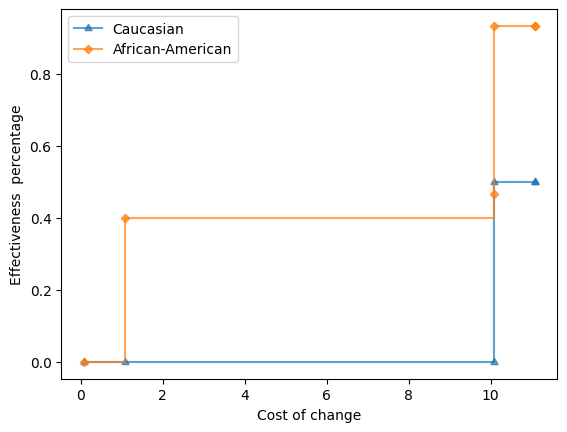

If juv_other_count = 1, priors_count = (-0.1, 1.0], sex = Male:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 0.14.
		Make juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 50.00% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 2.32% covered out of 548
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 0.14.
		Make juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 8.33% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 0.08
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.417.
	Cumulative effectiveness plot for the above recourses:


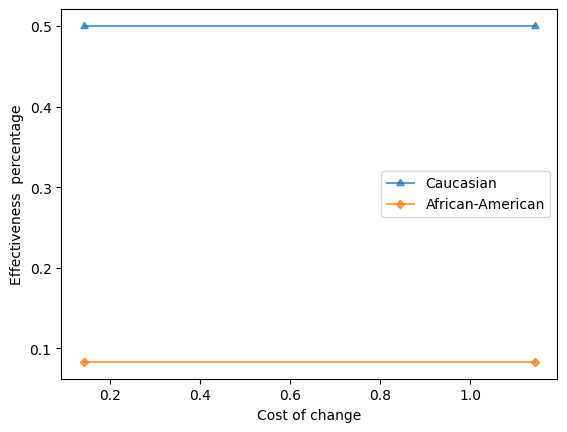

If age_cat = 25 - 45, c_charge_degree = F, juv_misd_count = 0, juv_other_count = 1:
	Protected Subgroup 'Caucasian', 2.05% covered out of 171
		Make juv_other_count = 0 with effectiveness 25.00% and counterfactual cost = 0.14.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 1.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 10.14.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 11.14.
		Aggregate cost of the above recourses = 0.75
	Protected Subgroup 'African-American', 2.32% covered out of 548
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 0.14.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 33.33% and counterfactual cost = 1.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 33.33% and counterfactual cost = 10.14.
		Mak

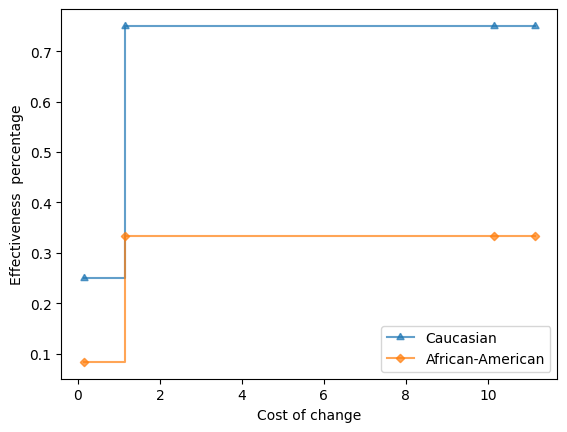

If age_cat = 25 - 45, juv_other_count = 1:
	Protected Subgroup 'Caucasian', 2.05% covered out of 171
		Make juv_other_count = 0 with effectiveness 25.00% and counterfactual cost = 0.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 10.14.
		Aggregate cost of the above recourses = 0.75
	Protected Subgroup 'African-American', 6.38% covered out of 548
		Make juv_other_count = 0 with effectiveness 15.15% and counterfactual cost = 0.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 33.33% and counterfactual cost = 10.14.
		Aggregate cost of the above recourses = 0.33
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.417.
	Cumulative effectiveness plot for the above recourses:


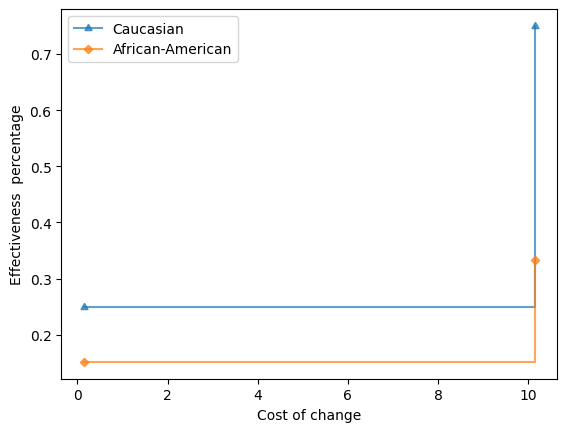

If c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 0.00% and counterfactual cost = 1.08.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 50.00% and counterfactual cost = 1.08.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 50.00% and counterfactual cost = 2.08.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 50.00% and counterfactual cost = 2.08.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 1.93% covered out of 548
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 10.00% and counterfactual cost = 1.08.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 80.00% and counterfactual cost = 1.08.
		Make c_charge_degree = M, j

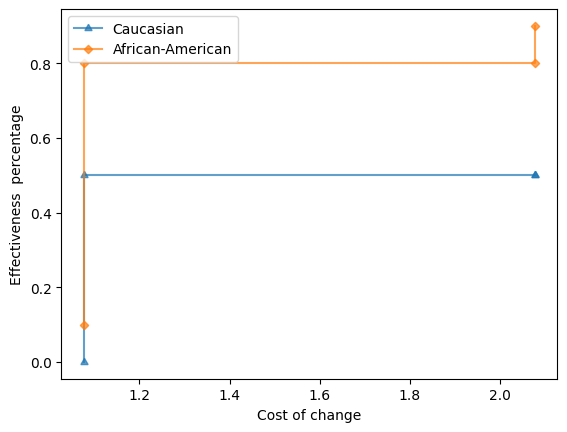

If age_cat = 25 - 45, c_charge_degree = F, juv_other_count = 2:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 0.29.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 1.29.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 10.29.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 11.29.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 1.55% covered out of 548
		Make juv_other_count = 0 with effectiveness 12.50% and counterfactual cost = 0.29.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 37.50% and counterfactual cost = 1.29.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 10.29.
		Make age_cat = Greate

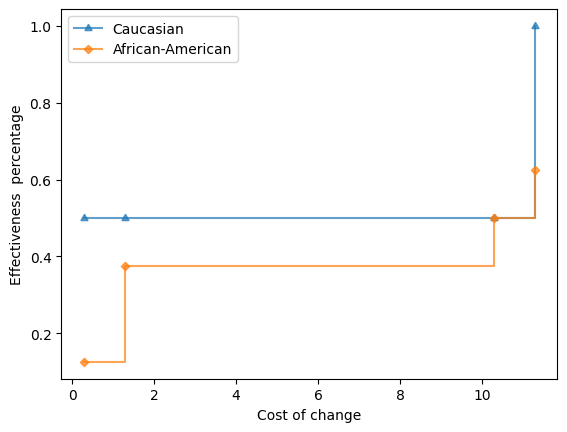

If age_cat = 25 - 45, juv_fel_count = 0, juv_misd_count = 1, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.08.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 10.08.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 4.06% covered out of 548
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.08.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 14.29% and counterfactual cost = 10.08.
		Aggregate cost of the above recourses = 0.14
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.357.
	Cumulative effectiveness plot for the above recourses:


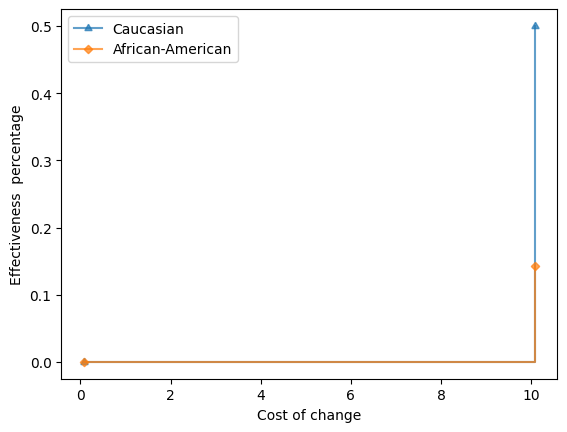

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 1, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 2.05% covered out of 171
		Make juv_fel_count = 0 with effectiveness 0.00% and counterfactual cost = 0.1.
		Make c_charge_degree = M, juv_fel_count = 0 with effectiveness 25.00% and counterfactual cost = 1.1.
		Make age_cat = Greater than 45, juv_fel_count = 0 with effectiveness 25.00% and counterfactual cost = 10.1.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_fel_count = 0 with effectiveness 25.00% and counterfactual cost = 11.1.
		Aggregate cost of the above recourses = 0.25
	Protected Subgroup 'African-American', 2.90% covered out of 548
		Make juv_fel_count = 0 with effectiveness 0.00% and counterfactual cost = 0.1.
		Make c_charge_degree = M, juv_fel_count = 0 with effectiveness 40.00% and counterfactual cost = 1.1.
		Make age_cat = Greater than 45, juv_fel_count = 0 with effectiveness 46.67% and counterfactual cost = 10.1.
		Make age_cat = Greater tha

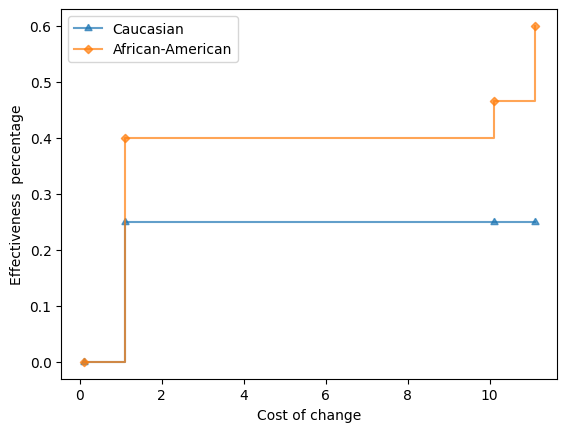

If age_cat = 10-25, juv_misd_count = 0, sex = Female:
	Protected Subgroup 'Caucasian', 1.54% covered out of 171
		Make age_cat = 25 - 45 with effectiveness 66.67% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45 with effectiveness 66.67% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.67
	Protected Subgroup 'African-American', 1.93% covered out of 548
		Make age_cat = 25 - 45 with effectiveness 80.00% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.333.
	Cumulative effectiveness plot for the above recourses:


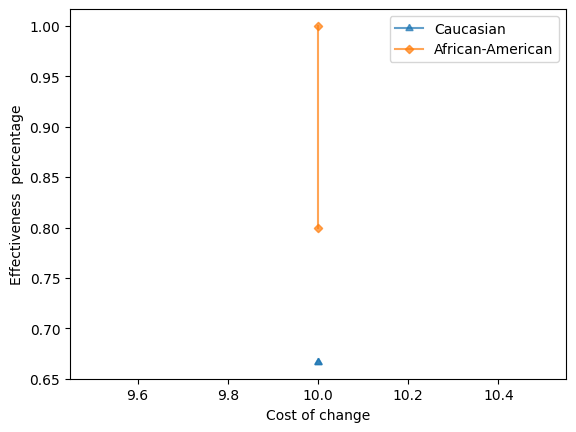

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.08.
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 1.08.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 10.08.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 11.08.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 3.29% covered out of 548
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.08.
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 5.88% and counterfactual cost = 1.08.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 17.65% and counterfactual cost = 10.

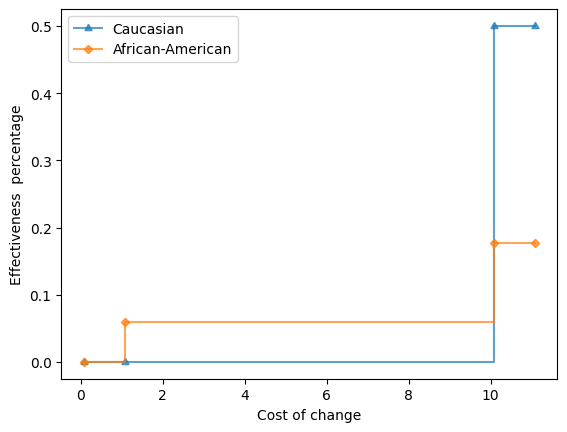

If age_cat = 10-25, juv_misd_count = 2:
	Protected Subgroup 'Caucasian', 2.05% covered out of 171
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.15.
		Make age_cat = 25 - 45, juv_misd_count = 0 with effectiveness 25.00% and counterfactual cost = 10.15.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 75.00% and counterfactual cost = 10.15.
		Aggregate cost of the above recourses = 0.75
	Protected Subgroup 'African-American', 1.35% covered out of 548
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.15.
		Make age_cat = 25 - 45, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 10.15.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 42.86% and counterfactual cost = 10.15.
		Aggregate cost of the above recourses = 0.43
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.321.
	Cumulative effectiveness plot for the above recourses:


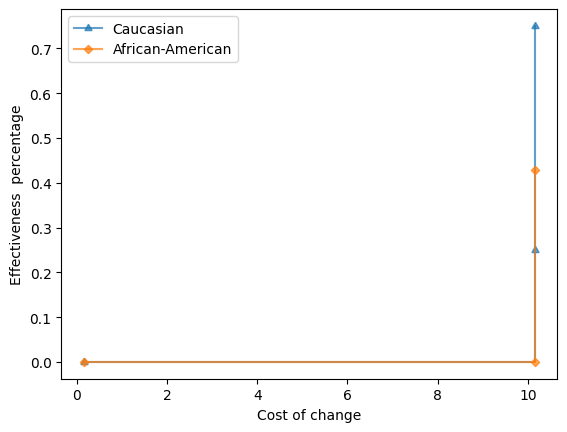

If age_cat = 25 - 45, c_charge_degree = F, sex = Male:
	Protected Subgroup 'Caucasian', 43.59% covered out of 171
		Make c_charge_degree = M with effectiveness 54.12% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 57.65% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 70.59% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 0.71
	Protected Subgroup 'African-American', 44.10% covered out of 548
		Make c_charge_degree = M with effectiveness 31.14% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 35.96% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 38.60% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 0.39
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.32.
	Cumulative effectiveness plot for the above recourses:


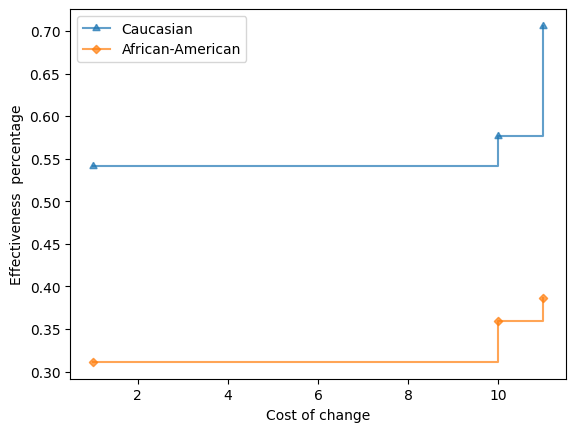

If age_cat = 25 - 45, juv_fel_count = 1, juv_misd_count = 0, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 2.05% covered out of 171
		Make juv_fel_count = 0 with effectiveness 0.00% and counterfactual cost = 0.1.
		Make age_cat = Greater than 45, juv_fel_count = 0 with effectiveness 25.00% and counterfactual cost = 10.1.
		Aggregate cost of the above recourses = 0.25
	Protected Subgroup 'African-American', 1.74% covered out of 548
		Make juv_fel_count = 0 with effectiveness 0.00% and counterfactual cost = 0.1.
		Make age_cat = Greater than 45, juv_fel_count = 0 with effectiveness 55.56% and counterfactual cost = 10.1.
		Aggregate cost of the above recourses = 0.56
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.306.
	Cumulative effectiveness plot for the above recourses:


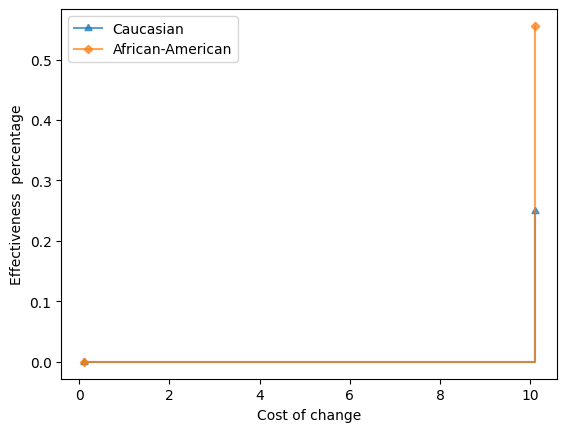

In [17]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

If age_cat = 10-25, juv_misd_count = 0, juv_other_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 5.13% covered out of 171
		Make juv_other_count = 0 with effectiveness 30.00% and counterfactual cost = 0.14.
		Aggregate cost of the above recourses = 0.14
	Protected Subgroup 'African-American', 3.87% covered out of 548
		Make juv_other_count = 0 with effectiveness 5.00% and counterfactual cost = 0.14.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 60.00% and counterfactual cost = 10.14.
		Aggregate cost of the above recourses = 10.14
	Bias against African-American due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


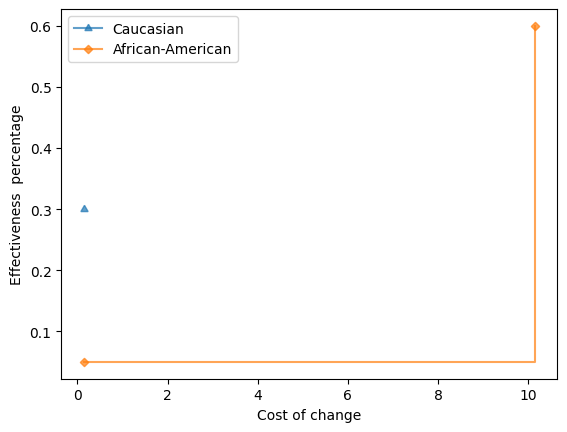

If age_cat = 10-25, juv_other_count = 1, priors_count = (-0.1, 1.0]:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 0.14.
		Aggregate cost of the above recourses = 0.14
	Protected Subgroup 'African-American', 2.51% covered out of 548
		Make juv_other_count = 0 with effectiveness 15.38% and counterfactual cost = 0.14.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 10.14.
		Aggregate cost of the above recourses = 10.14
	Bias against African-American due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


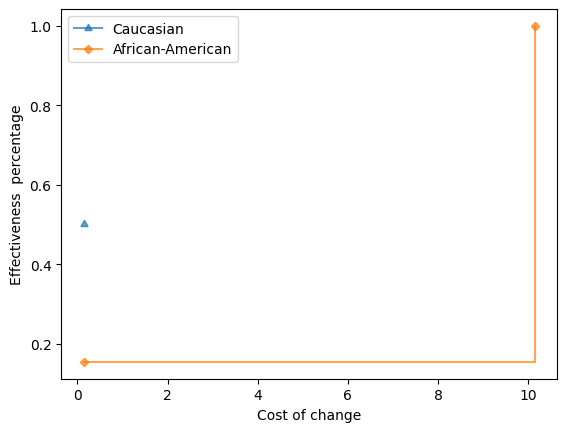

If age_cat = 10-25, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make priors_count = (-0.1, 1.0] with effectiveness 33.33% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 2.90% covered out of 548
		Make priors_count = (-0.1, 1.0] with effectiveness 20.00% and counterfactual cost = 1.0.
		Make age_cat = 25 - 45, priors_count = (1.0, 5.0] with effectiveness 20.00% and counterfactual cost = 11.0.
		Make age_cat = 25 - 45, priors_count = (-0.1, 1.0] with effectiveness 86.67% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


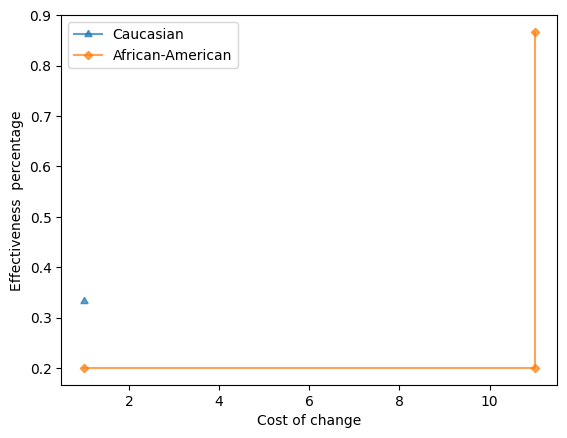

If age_cat = 25 - 45, juv_other_count = 2:
	Protected Subgroup 'Caucasian', 2.05% covered out of 171
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 0.29.
		Aggregate cost of the above recourses = 0.29
	Protected Subgroup 'African-American', 1.55% covered out of 548
		Make juv_other_count = 0 with effectiveness 12.50% and counterfactual cost = 0.29.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 10.29.
		Aggregate cost of the above recourses = 10.29
	Bias against African-American due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


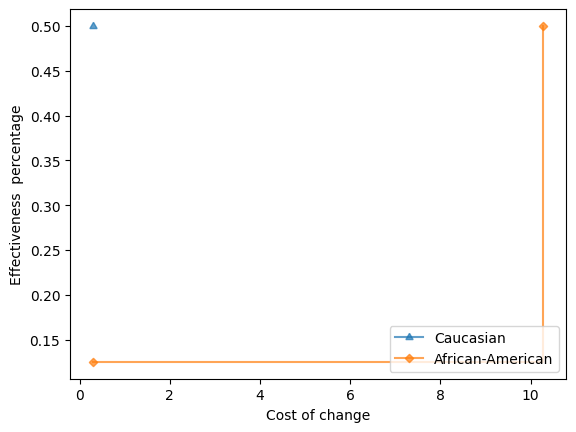

If age_cat = 25 - 45, c_charge_degree = F, juv_other_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 1.54% covered out of 171
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 0.14.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 1.14
	Protected Subgroup 'African-American', 3.68% covered out of 548
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 0.14.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 26.32% and counterfactual cost = 1.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 26.32% and counterfactual cost = 10.14.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_count = 0 with effectiveness 42.11% and counterfactual cost = 11.14.
		Aggregate cost of the above recourses = 11.14
	Bias against African-American due to Equal Effectiveness. Unfairness score = 1

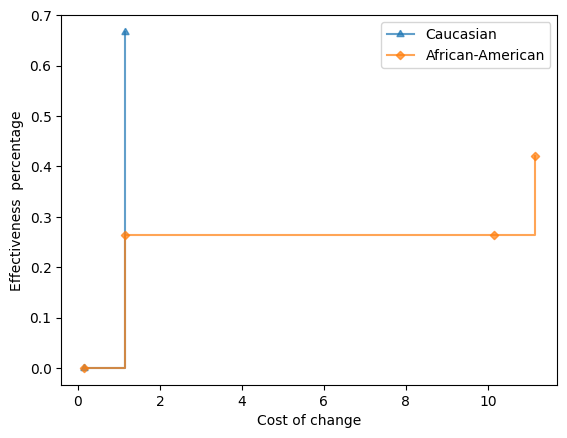

If age_cat = 25 - 45, c_charge_degree = F:
	Protected Subgroup 'Caucasian', 46.67% covered out of 171
		Make c_charge_degree = M with effectiveness 51.65% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 47.97% covered out of 548
		Make c_charge_degree = M with effectiveness 29.03% and counterfactual cost = 1.0.
		Make age_cat = Greater than 45 with effectiveness 39.52% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 9.0.
	Cumulative effectiveness plot for the above recourses:


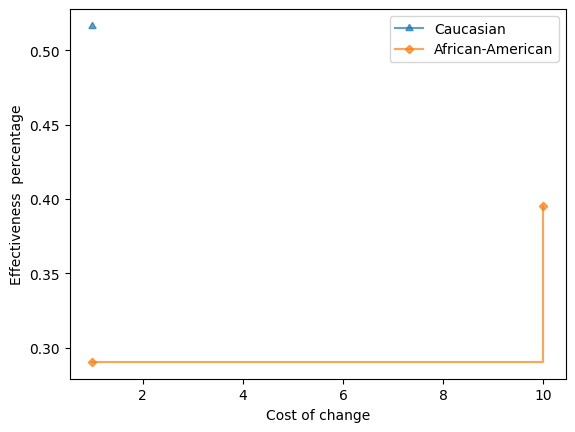

If age_cat = 10-25, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 14.36% covered out of 171
		Make priors_count = (-0.1, 1.0] with effectiveness 46.43% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 11.41% covered out of 548
		Make priors_count = (-0.1, 1.0] with effectiveness 27.12% and counterfactual cost = 1.0.
		Make age_cat = 25 - 45 with effectiveness 27.12% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45 with effectiveness 88.14% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 9.0.
	Cumulative effectiveness plot for the above recourses:


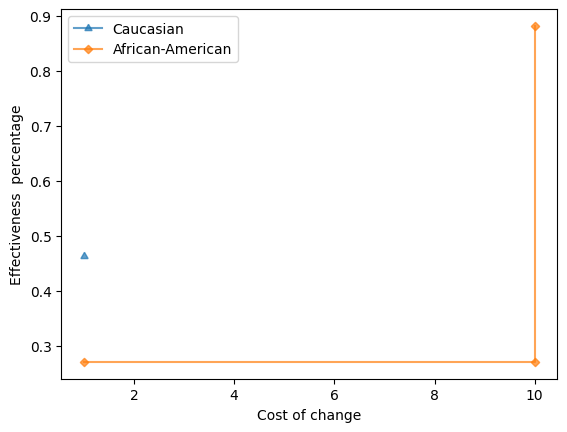

If age_cat = 10-25, juv_other_count = 1, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 66.67% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 1.14
	Protected Subgroup 'African-American', 1.93% covered out of 548
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 20.00% and counterfactual cost = 1.14.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 20.00% and counterfactual cost = 10.14.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 10.14.
		Aggregate cost of the above recourses = 10.14
	Bias against African-American due to Equal Effectiveness. Unfairness score = 9.0.
	Cumulative effectiveness plot for the above recourses:


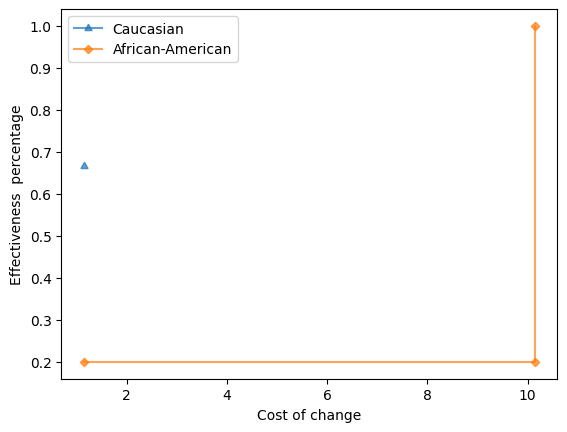

If age_cat = 10-25, c_charge_degree = F, juv_misd_count = 1:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.08.
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 1.08.
		Make age_cat = 25 - 45, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 10.08.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 10.08.
		Aggregate cost of the above recourses = 10.08
	Protected Subgroup 'African-American', 3.29% covered out of 548
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 0.08.
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 35.29% and counterfactual cost = 1.08.
		Aggregate cost of the above recourses = 1.08
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 9.0.
	Cumulative effectiveness plot for the above recourses:

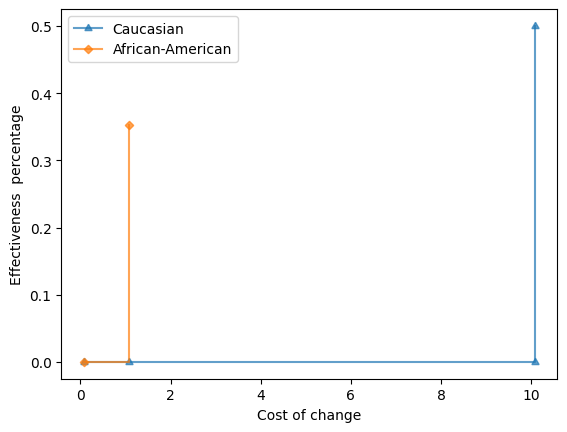

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_other_count = 0, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 5.13% covered out of 171
		Make priors_count = (-0.1, 1.0] with effectiveness 30.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 6.00% covered out of 548
		Make priors_count = (-0.1, 1.0] with effectiveness 29.03% and counterfactual cost = 1.0.
		Make c_charge_degree = M, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 1.0.
	Cumulative effectiveness plot for the above recourses:


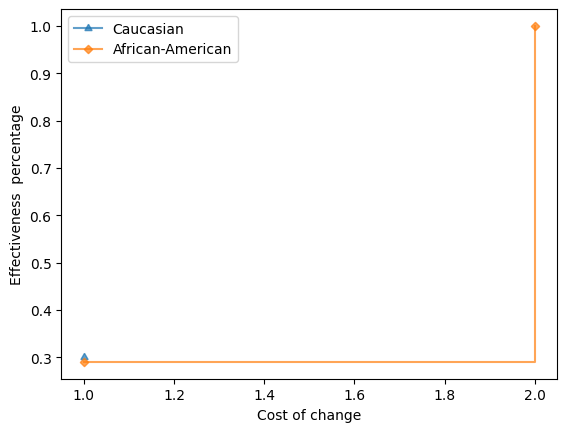

If juv_misd_count = 0, juv_other_count = 1, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make juv_other_count = 0 with effectiveness 16.67% and counterfactual cost = 0.14.
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 66.67% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 1.14
	Protected Subgroup 'African-American', 2.71% covered out of 548
		Make juv_other_count = 0 with effectiveness 35.71% and counterfactual cost = 0.14.
		Aggregate cost of the above recourses = 0.14
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 1.0.
	Cumulative effectiveness plot for the above recourses:


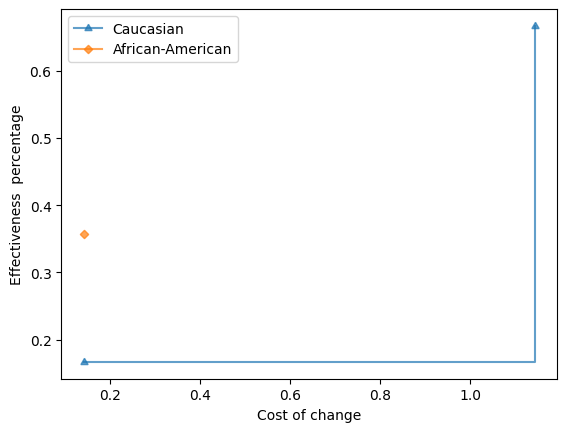

If age_cat = 10-25, c_charge_degree = F, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Caucasian', 2.56% covered out of 171
		Make priors_count = (-0.1, 1.0] with effectiveness 40.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 2.51% covered out of 548
		Make priors_count = (-0.1, 1.0] with effectiveness 15.38% and counterfactual cost = 1.0.
		Make c_charge_degree = M, priors_count = (-0.1, 1.0] with effectiveness 69.23% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 1.0.
	Cumulative effectiveness plot for the above recourses:


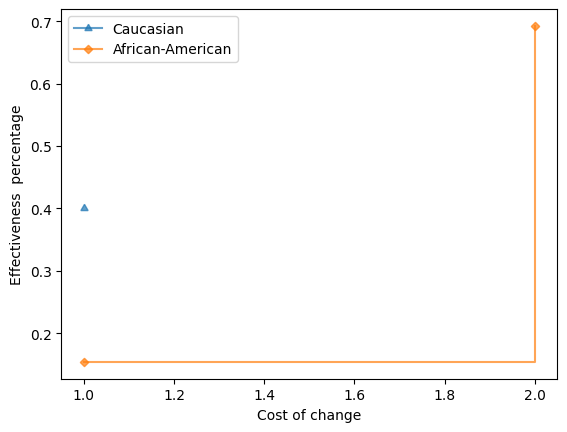

If age_cat = 10-25, c_charge_degree = F, juv_other_count = 1, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 1.54% covered out of 171
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 33.33% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 1.14
	Protected Subgroup 'African-American', 1.55% covered out of 548
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 0.00% and counterfactual cost = 1.14.
		Make c_charge_degree = M, juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 75.00% and counterfactual cost = 2.14.
		Aggregate cost of the above recourses = 2.14
	Bias against African-American due to Equal Effectiveness. Unfairness score = 1.0.
	Cumulative effectiveness plot for the above recourses:


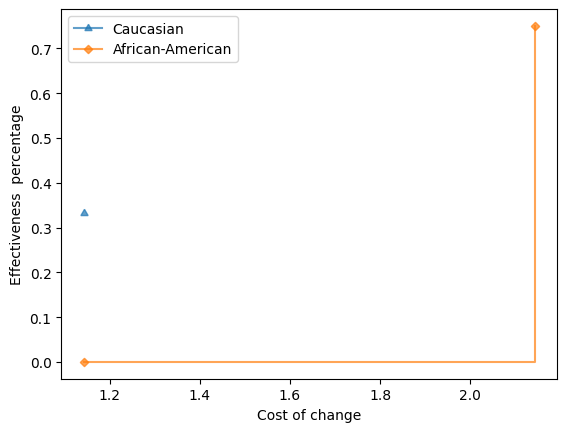

In [18]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

If juv_other_count = 3:
	Protected Subgroup 'Caucasian', 1.54% covered out of 171
		Make juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 0.43.
		Aggregate cost of the above recourses = 0.67
	Protected Subgroup 'African-American', 1.16% covered out of 548
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 0.43.
		Aggregate cost of the above recourses = 0.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.667.
	Cumulative effectiveness plot for the above recourses:


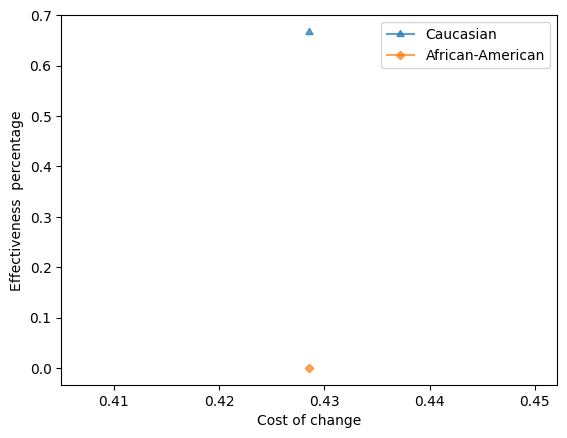

If age_cat = 10-25, juv_other_count = 1, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 66.67% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 0.67
	Protected Subgroup 'African-American', 1.93% covered out of 548
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 20.00% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 0.20
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.467.
	Cumulative effectiveness plot for the above recourses:


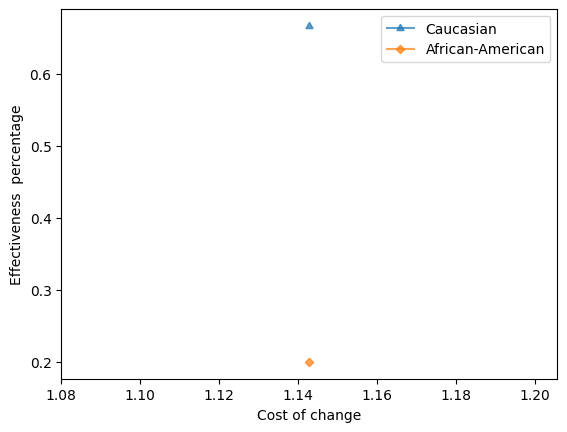

If age_cat = 25 - 45, c_charge_degree = F, juv_other_count = 1:
	Protected Subgroup 'Caucasian', 2.05% covered out of 171
		Make juv_other_count = 0 with effectiveness 25.00% and counterfactual cost = 0.14.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 0.75
	Protected Subgroup 'African-American', 3.87% covered out of 548
		Make juv_other_count = 0 with effectiveness 5.00% and counterfactual cost = 0.14.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 30.00% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 0.30
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.45.
	Cumulative effectiveness plot for the above recourses:


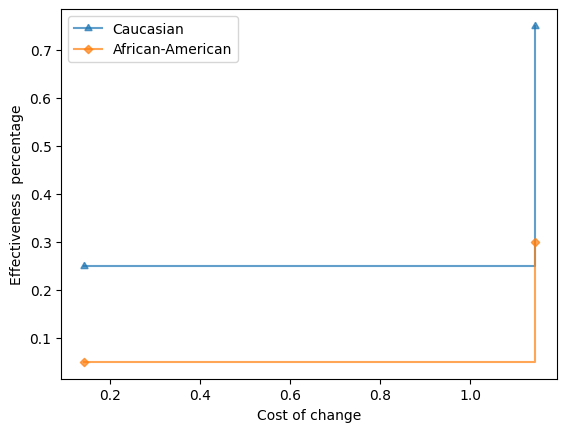

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 1.08.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'African-American', 2.71% covered out of 548
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 42.86% and counterfactual cost = 1.08.
		Aggregate cost of the above recourses = 0.43
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.429.
	Cumulative effectiveness plot for the above recourses:


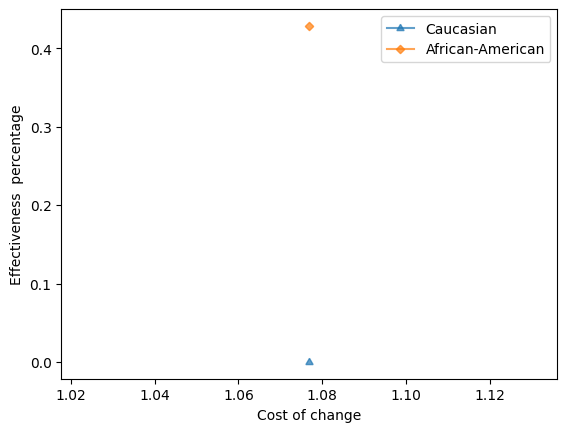

If age_cat = 10-25, juv_other_count = 1, priors_count = (-0.1, 1.0], sex = Male:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 0.14.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 2.32% covered out of 548
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 0.14.
		Aggregate cost of the above recourses = 0.08
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.417.
	Cumulative effectiveness plot for the above recourses:


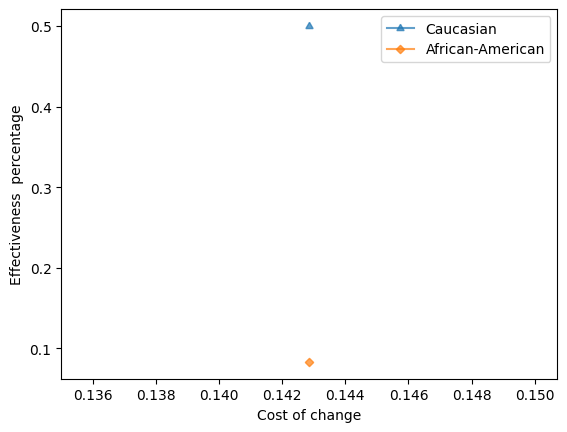

If juv_other_count = 1, priors_count = (-0.1, 1.0], sex = Male:
	Protected Subgroup 'Caucasian', 3.08% covered out of 171
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 0.14.
		Make juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 50.00% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 2.32% covered out of 548
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 0.14.
		Make juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 8.33% and counterfactual cost = 1.14.
		Aggregate cost of the above recourses = 0.08
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.417.
	Cumulative effectiveness plot for the above recourses:


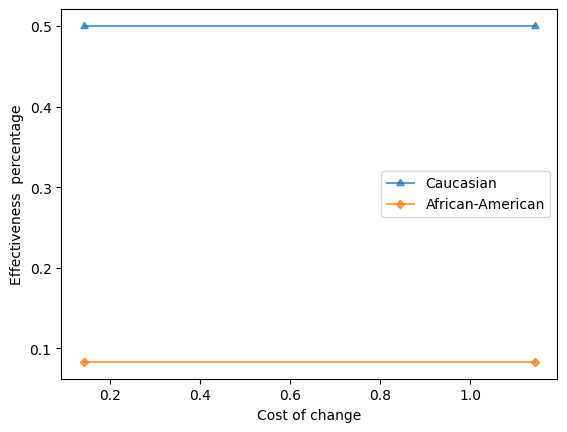

If c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 0.00% and counterfactual cost = 1.08.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 50.00% and counterfactual cost = 1.08.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 50.00% and counterfactual cost = 2.08.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 50.00% and counterfactual cost = 2.08.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 1.93% covered out of 548
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 10.00% and counterfactual cost = 1.08.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 80.00% and counterfactual cost = 1.08.
		Make c_charge_degree = M, j

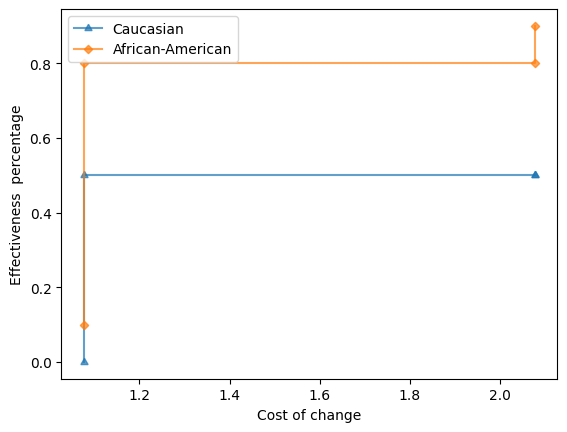

If age_cat = 25 - 45, juv_other_count = 2:
	Protected Subgroup 'Caucasian', 2.05% covered out of 171
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 0.29.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 1.55% covered out of 548
		Make juv_other_count = 0 with effectiveness 12.50% and counterfactual cost = 0.29.
		Aggregate cost of the above recourses = 0.12
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.375.
	Cumulative effectiveness plot for the above recourses:


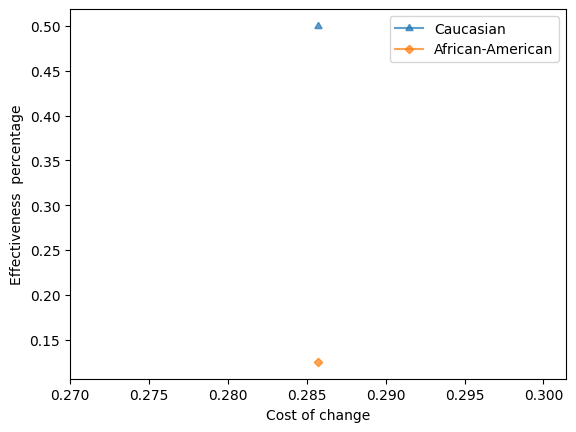

If age_cat = 10-25, c_charge_degree = F, sex = Female:
	Protected Subgroup 'Caucasian', 1.54% covered out of 171
		Make c_charge_degree = M with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age_cat = 25 - 45 with effectiveness 66.67% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45 with effectiveness 66.67% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.67
	Protected Subgroup 'African-American', 1.55% covered out of 548
		Make c_charge_degree = M with effectiveness 12.50% and counterfactual cost = 1.0.
		Make age_cat = 25 - 45 with effectiveness 87.50% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.333.
	Cumulative effectiveness plot for the above recourses:


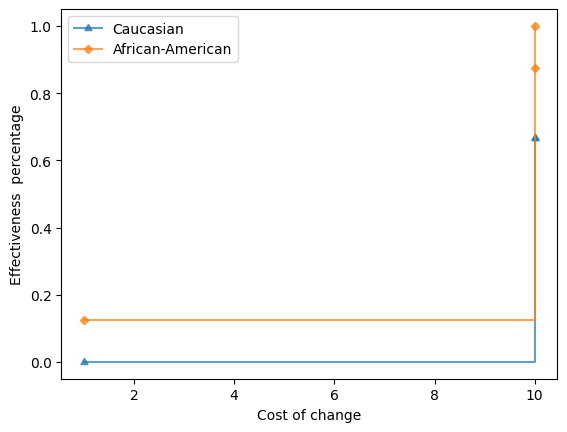

If age_cat = 10-25, juv_misd_count = 0, sex = Female:
	Protected Subgroup 'Caucasian', 1.54% covered out of 171
		Make age_cat = 25 - 45 with effectiveness 66.67% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45 with effectiveness 66.67% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.67
	Protected Subgroup 'African-American', 1.93% covered out of 548
		Make age_cat = 25 - 45 with effectiveness 80.00% and counterfactual cost = 10.0.
		Make age_cat = Greater than 45 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.333.
	Cumulative effectiveness plot for the above recourses:


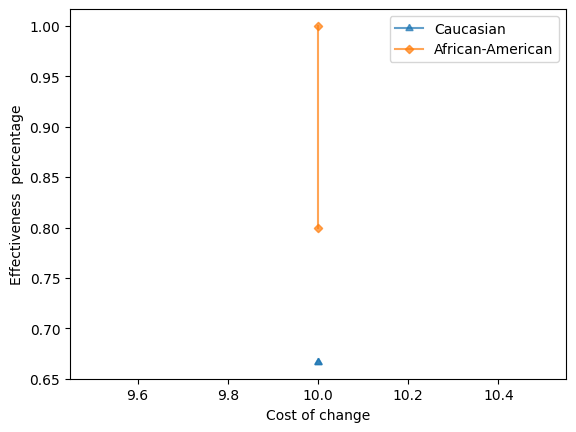

If juv_fel_count = 0, juv_misd_count = 1, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 0.00% and counterfactual cost = 1.08.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 50.00% and counterfactual cost = 1.08.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 2.71% covered out of 548
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 21.43% and counterfactual cost = 1.08.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 78.57% and counterfactual cost = 1.08.
		Aggregate cost of the above recourses = 0.79
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.286.
	Cumulative effectiveness plot for the above recourses:


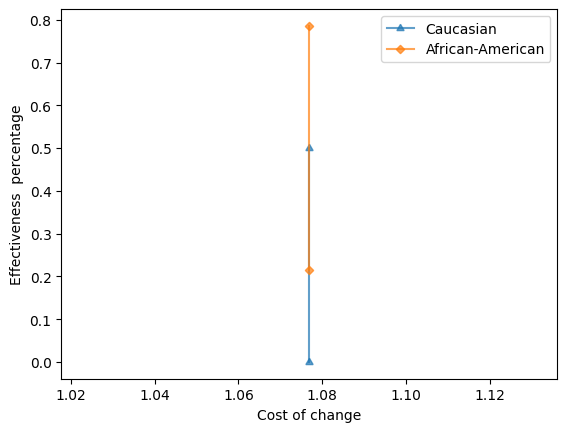

If age_cat = 10-25, juv_misd_count = 0, juv_other_count = 0, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Caucasian', 1.03% covered out of 171
		Make priors_count = (-0.1, 1.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'African-American', 1.35% covered out of 548
		Make priors_count = (-0.1, 1.0] with effectiveness 28.57% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.29
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.286.
	Cumulative effectiveness plot for the above recourses:


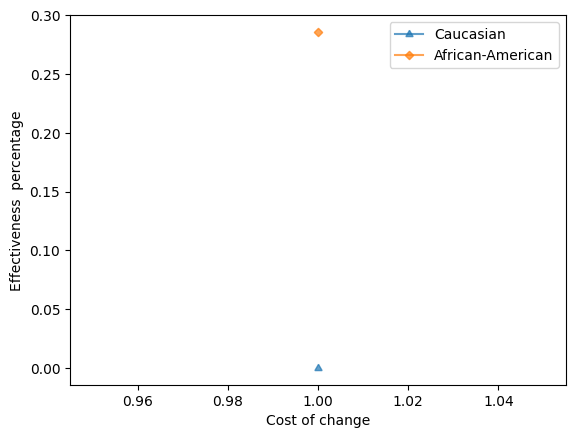

In [19]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

In [69]:
# affected_pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}

# top_rules,unfairness = facts.select_rules_subset_KStest(
#     rules_with_cumulative,
#     affected_pop_sizes,
#     top_count=50
# )

# print_recourse_report_KStest_cumulative(
#     top_rules,
#     population_sizes=pop_sizes,
#     unfairness = unfairness,
#     show_then_costs=True,
#     show_cumulative_plots=True
# )

In [70]:
end_time = time.time()

In [71]:
end_time - start_time

4.847071886062622

In [72]:
stats["metrics-time"] = end_time - start_time

In [73]:
stats

{'freq-itemsets-no': {'African-American': 1360,
  'Asian': 127,
  'Caucasian': 1431,
  'Hispanic': 1187,
  'Native American': 431,
  'Other': 879},
 'inter-groups-no': 95,
 'unaff-freq-itemsets-no': 2895,
 'valid-if-thens-time': 3.7144041061401367,
 'triples-no': 188,
 'subgroup-no': 88,
 'cumulative-time': 2.577716112136841,
 'metrics-time': 4.847071886062622}

In [74]:
stats["valid-if-thens-time"] + stats["cumulative-time"] + stats["metrics-time"]

11.1391921043396

In [79]:
np.sum(list(stats["freq-itemsets-no"].values())) - 1431

3984